#  Time Series Analysis of Github Commit Activity

Author: Vidya shree S

Date:14-12-2023

Some introductory notes to set the premise of the analysis:

1. Git was initially launched in 2005, the datapoints available could be from codebase migration from previous version tracking systems

2. Categories are assigned to repos to make the analysis easier in the EDA sections

**Key Findings:**

* **Data Alignment:** Rectifying discrepancies in the timeline, records from the future and past were corrected for specific repositories. To address potential gaps in GitHub activity on days without commits, a continuous date index was established at the repository level. This ensures a comprehensive timeline, facilitating effective time series analysis, even on days with no recorded commits

* **Diverse Repository Dynamics:** While the overall activity time series exhibited an upward trend, individual repositories displayed varied characteristics, including upward trends, downtrends, and level shifts. These differences in repository activities are influenced by specific events, project goals, and other factors

* **Time Series Decomposition:** Decomposition analyses revealed a prominent presence of both trend and seasonal characteristics in the overall time series. However, the day-level variations were notably high, introducing volatility to the system. To mitigate this, the data was aggregated to a weekly level, enhancing its suitability for forecasting purposes.

* **Forecasting:**  Primary goal in forecasting is to establish a baseline model based on univariate time series. Preceding forecasting, a meticulous study of correlation in the data guides the determination of trend and seasonal orders in SARIMA models. The forecast's efficacy is evaluated through a window or rolling method with prediction window of four weeks, measuring average MAPE and MAE values, which are reported as 12 % and 800 respectively.


# Importing necessary libraries

In [1]:
#!pip install ipympl
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00


In [2]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime
from time import strptime
import plotly.graph_objects as go
from dateutil import relativedelta
#from statsmodels.tsa.seasonal import seasonal_decompose
#import pylab
#from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from scipy.stats import shapiro
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import STL
import pmdarima as pm
import gc

In [4]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelspec migrate nbclassic
nbconvert nbextension notebook run server serverextension troubleshoot trust

Jupyter command `jupyter-labextension` not found.


# Function Definitions

In [5]:
#from datetime import datetime

def date_time(x):
    """
     Split the date string and parse the components

     Called in apply function
    """
    day_name, month_name, day_num, time, year,_ = x['datetime'].split()

    # Convert month name to month number
    month_num = strptime(month_name, '%b').tm_mon
    dt = datetime(int(year), month_num, int(day_num))

    return dt.strftime("%Y-%m-%d")


In [6]:
def evaluate_res(
    actual: np.ndarray, predicted: np.ndarray, metrics=("calculate_mae","calculate_mape","calculate_variance","calculate_bias")
):
    """
    Function for gathering the results as a dictionary
    actual: numpy array of actual value of train data
    predicted: numpy array of predicted value of test window
    """
    results = {}
    for name in metrics:
        try:
            metric_function = globals()[name]
            results[name] = metric_function(actual, predicted) #calling the function one by one for calculating the metric
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

In [7]:
def process_repo_day_level(github_repo):
  """
    github_repo: filtered github activity for a specific repo
    Create pandas date range based on the dates registered
    Merge based on the newly created continuous date index

  """

  all_dates = pd.date_range(start=github_repo['date'].min(),
                          end=github_repo['date'].max(), freq='D')

  #Create new index based on the repo and dates
  new_index = pd.MultiIndex.from_product([all_dates,github_repo['repo'].unique()], names=['date', 'repo'])

  # Reindex the DataFrame with the new MultiIndex
  full_df=pd.DataFrame(index=new_index).reset_index()
  github_repo['date']=pd.to_datetime(github_repo['date'])
  github_repo = pd.merge(full_df,github_repo, on=['date', 'repo'], how='left')
  github_repo.sort_values(by=['repo', 'date'], inplace=True)
 # github_df_repo_all=github_df_repo_all.drop(columns=['year'])

  github_repo['commit_count']=github_repo['commit_count'].fillna(0)
  github_repo['author_count']=github_repo['author_count'].fillna(0)

  return github_repo


In [8]:

def plot_time_series(df, column, title, ylabel,horizontal_dates):

    %matplotlib inline
    """
    Create an interactive plot using matplotlib
    df: dataframe to plot
    column: column name to plot
    title: plot title
    ylabel: label for the y-axis
    horizontal_dates: marking commit of new repos

    """

    # Convert the index to datetime if not already
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(df.index, df[column], label=column, linewidth=1, color='b')

    for date in horizontal_dates:
            ax.axvline(pd.to_datetime(date), color='r', linestyle='--', linewidth=1)


   # Format the x-axis and display only years given the span of data
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.grid(True, linestyle='--', alpha=0.7)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    ax.legend()

    plt.tight_layout()
    plt.show()


In [100]:
def plot_github_activity_repo(df, cat):
    """
    Plot GitHub commit activity for specified repositories.
    - cat: Name of the cat to plot.
    - df: DataFrame containing the GitHub activity data.

    """

    # Filter the table on category
    lst_repo = repo_summ[repo_summ['categorisation'] == cat]['repo'].unique() ## Cretae a list carrying repo names
    nrows = int(np.ceil(len(lst_repo) / 2))

    # Calculate the number of rows needed for the subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 8))

    # Flatten the axs before looping
    axs = axs.flatten()
    for i, repo in enumerate(lst_repo):
          data = df.loc[df['repo'] == repo]
          axs[i].plot(data['date'], data['commit_count'])
          axs[i].set_title('github commit activity '+repo)
          axs[i].set_xlabel('Day')
          axs[i].set_ylabel('Github commit counts')

    # Remove any unused subplots
    if len(lst_repo) % 2 != 0:
        fig.delaxes(axs[-1])

    plt.tight_layout()
    plt.show()


In [13]:
#Convert this to function
def decomp_plot_stl(df,keyword,column):

        #decomp_seasonal = seasonal_decompose(github_df_daily_fil["commit"]+0.1e-9, model='multliplicative') #Period need not be passed the frequency of index is set to daily
        stl = STL(df[column],robust=True)
        decomp_seasonal = stl.fit()
        fig = go.Figure() # Create an interactive plot with slider

        # Add original time series
        fig.add_trace(go.Scatter(x=df.index, y=df[column], mode='lines', name='Original'))

        # Add trace after filtering by keyword to perform corresponding plot
        if keyword=="resid":
            fig.add_trace(go.Scatter(x=df.index, y=decomp_seasonal.resid, mode='lines', name='Residual'))

        elif keyword=="seasonal":
            fig.add_trace(go.Scatter(x=df.index, y=decomp_seasonal.seasonal, mode='lines', name='Seasonal'))

        else:
              fig.add_trace(go.Scatter(x=df.index, y=decomp_seasonal.trend, mode='lines', name='Trend'))

        # Update layout for slider
        fig.update_layout(
            sliders=[{
                'active': 0,
                'steps': [
                    {'label': 'Original', 'method': 'update', 'args': [{'visible': [True, False]}]},
                    {'label': keyword, 'method': 'update', 'args': [{'visible': [False, True]}]}
                ]
            }]
        )

        # Update axis labels and title
        fig.update_layout(
            title='Interactive '+ keyword + " Decomposition",
            xaxis_title='Date',
            width=800,
            height=500,
            yaxis_title='Commit Counts'
        )

        fig.show()

In [14]:
def summarise_repo_level_info(df):
  """
   Summarise the df at category level
  """
  repo_summ=df.groupby(['repo','categorisation']).agg({'date':['min','max'],'commit_count':'sum'})

  # Calculate the mode value on author variable
  author_summ=df.groupby(['repo','categorisation'])['author_count'].agg(pd.Series.mean)
  author_summ=pd.DataFrame(author_summ).reset_index()
  author_summ=author_summ.rename(columns={'author':'author_mean'})

  repo_summ= pd.merge(repo_summ,author_summ,on='repo',how="left")

  repo_summ=pd.DataFrame(repo_summ).reset_index()
  repo_summ.columns = repo_summ.columns.map(''.join)
  repo_summ.columns

  delta = repo_summ.apply(lambda row: relativedelta.relativedelta(row['datemax'],row['datemin']),axis=1)
  repo_summ['delta_years'] = delta.apply(lambda x: x.years)
  repo_summ['delta_months'] = delta.apply(lambda x: x.months)
#commit_sum.columns = commit_sum.columns.to_flat_index()
  repo_summ.sort_values(by=['datemin','commit_countsum'],inplace=True)  #,ascending=False)

  return repo_summ

In [15]:
# Error evaluation functions
def calculate_mae(y_true,y_pred):
   # y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs((y_true - y_pred)))  #Mean absolute error is calculated as average of absolute difference between the actual and forecasted value
    #mae = mean_absolute_error(y_true, y_pred)
    return mae

def calculate_mape(y_true, y_pred):
  #  y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_variance(y_true,y_pred):
    variance = np.var(y_pred)
    return variance


def calculate_bias(y_true, y_pred):
    bias = np.mean(y_true - y_pred)
    return bias


# 1 Data Acquisition




In [17]:
drive.mount('/content/drive')
#%cd drive/MyDrive

Mounted at /content/drive


In [20]:
os.getcwd()
os.listdir('/content/drive/MyDrive/Colab Notebooks')

['modules.py',
 'VAE',
 'VAE_CIFAR.ipynb',
 'Initial Setup.ipynb',
 'Untitled',
 'github_data.csv',
 'github-commit-analysis.ipynb',
 'github.npy',
 'github-commit-time-series.ipynb',
 'repo_cat (1).gsheet',
 'repo_cat.gsheet',
 'repo_cat.csv',
 'github-commit-time-series_v2.ipynb']

In [21]:
github_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/github_data.csv')

In [22]:
github_df.head()

,commit,author,date,message,repo
0,692bba578efb5e305c9b116568e5aad75b3fdbb3,Mortada Mehyar <mortada@users.noreply.github.com>,Wed Apr 21 12:27:07 2021 +0800,DOC: add example for plotting asymmetrical err...,pandas-dev/pandas
1,855696cde0ef5d80a7d4bd3f6a2940c5a2fecb3f,Patrick Hoefler <61934744+phofl@users.noreply....,Wed Apr 21 01:23:07 2021 +0200,Add keyword sort to pivot_table (#40954),pandas-dev/pandas
2,eaaefd140289a5103679ac6748567f724c7be56a,attack68 <24256554+attack68@users.noreply.gith...,Wed Apr 21 01:21:22 2021 +0200,ENH: `Styler.highlight_quantile` method (#40926),pandas-dev/pandas
3,aab87997058f3c74ba70286620ebe792ee4ef169,attack68 <24256554+attack68@users.noreply.gith...,Wed Apr 21 01:01:03 2021 +0200,ENH: add `decimal` and `thousands` args to `St...,pandas-dev/pandas
4,9c43cd7675d96174051e470de1f45e2bf7c9ebdc,Simon Hawkins <simonjayhawkins@gmail.com>,Tue Apr 20 23:58:18 2021 +0100,[ArrowStringArray] Use utf8_upper and utf8_low...,pandas-dev/pandas


The various descriptives of the dataset is given below.

In [23]:
github_df.describe().transpose()

,count,unique,top,freq
commit,4336299,4336299,692bba578efb5e305c9b116568e5aad75b3fdbb3,1
author,4336299,89436,chromium-autoroll <chromium-autoroll@skia-publ...,36339
date,4336299,4268305,Wed Nov 1 03:56:19 2017 +1000,137
message,4335970,4217716,Merge remote-tracking branch 'origin/master' i...,12753
repo,4336299,34,torvalds/linux,998326


In [24]:
github_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336299 entries, 0 to 4336298
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   commit   object
 1   author   object
 2   date     object
 3   message  object
 4   repo     object
dtypes: object(5)
memory usage: 165.4+ MB


In [25]:
# Changing the column name for date column
github_df=github_df.rename(columns={'date':'datetime'})

In [26]:
#Check for null values
github_df.isna().sum()

commit        0
author        0
datetime      0
message     329
repo          0
dtype: int64

There are missing values in the 'message' column, while other values are fully populated. All the columns are of Object datatype

In [27]:
# Converting the long format date column to date, day and year columns

github_df['date']=github_df.apply(date_time,axis=1)
github_df['year']=pd.to_datetime(github_df['date']).dt.year
github_df["day"]=[x.split()[0] for x in github_df["datetime"]] #Extract day from the datetime column

# 2 Data Pre-Processing
•	The long datetime format column is converted to a date format and set as the index for time series analysis

•	The commit data is aggregated to a daily frequency to facilitate a comprehensive analysis of commits at **repo and overall level**


Summarising the daily activity at repository level by counting the number of commit hash and unique author.

In [28]:
# Group the dataset by day,repo to summarise commit daily count and unique authors count
github_df_repo=github_df.groupby(['date','year','repo','day']).agg({'commit':'count','author':'nunique'}).reset_index()
github_df_repo.head(2)
print(github_df_repo.shape)

(150692, 6)


In [29]:
github_df_repo=github_df_repo.rename(columns={'commit':'commit_count','author':'author_count'}) #Rename the column to more intuitive names

In [30]:
github_df_repo['commit_count'].sum() # QC - The sum is matching with the total records.
#github_df_repo.shape

4336299

In [31]:
github_df_repo.groupby(['day'])['commit_count'].sum()

day
Fri    722912
Mon    695170
Sat    303735
Sun    271963
Thu    770721
Tue    785835
Wed    785963
Name: commit_count, dtype: int64

It can observed that the number of commits on weekends  are naturally lower compared to any other day of the week.

In [32]:
date_check=github_df_repo.groupby(['year','repo'])['commit_count'].sum().reset_index()
date_check.tail()

,year,repo,commit_count
546,2021,torvalds/linux,12693
547,2021,v8/v8,2160
548,2030,torvalds/linux,1
549,2037,torvalds/linux,1
550,2085,torvalds/linux,1


In [33]:
date_check_1=github_df_repo.groupby(['year','repo'])['commit_count'].sum().reset_index()
date_check_1.groupby('repo')['year'].min().sort_values().head()

repo
torvalds/linux         1970
golang/go              1972
gcc-mirror/gcc         1988
python/cpython         1990
freebsd/freebsd-src    1993
Name: year, dtype: int64

In [34]:
date_check_1.groupby('year')['commit_count'].sum().head(6)

year
1970      1
1972      1
1974      1
1988      3
1989      4
1990    114
Name: commit_count, dtype: int64



#### Records with Dates in the Future:
- Three records with dates in the future have been identified and removed

#### Records with Dates in the Past:
- Golang and Linux repo commit dates are inaccurate because the development of Linux did not start until the early 1990s, and Golang was developed in the 2000s. These records were removed from further analysis


In [35]:
# Filtering the dataframe to retain complete data
github_df_repo=github_df_repo[(github_df_repo['year']>1989) & (github_df_repo['year']<2023)]
github_df_repo.shape #12 records were removed in total by filtering on years

(150680, 6)

### Continuous Data Handling for Time Series Analysis

To address potential gaps in GitHub activity due to days without commits, create a continuous date index at the repository level. This ensures a complete timeline for effective time series analysis, providing insights even on days with no recorded commits.


In [36]:
lst_repo= github_df_repo['repo'].unique()
lst_repo # Display unique repositories

array(['gcc-mirror/gcc', 'python/cpython', 'freebsd/freebsd-src',
       'openbsd/src', 'apache/httpd', 'postgres/postgres', 'scipy/scipy',
       'llvm/llvm-project', 'chromium/chromium', 'torvalds/linux',
       'numpy/numpy', 'nginx/nginx', 'matplotlib/matplotlib',
       'ipython/ipython', 'tidyverse/ggplot2', 'golang/go', 'v8/v8',
       'nodejs/node', 'pandas-dev/pandas', 'scikit-learn/scikit-learn',
       'apache/spark', 'opencv/opencv', 'rust-lang/rust', 'apple/swift',
       'rstudio/rstudio', 'pytorch/pytorch', 'facebook/react',
       'kubernetes/kubernetes', 'microsoft/TypeScript', 'angular/angular',
       'jupyterlab/jupyterlab', 'tensorflow/tensorflow',
       'microsoft/vscode', 'denoland/deno'], dtype=object)

In total, there are 34 repositories

In [37]:
github_df_repo_all=pd.DataFrame() # Declare a blank dataframe and then append the information in the for loop

for i in lst_repo:
  github_repo=github_df_repo.loc[github_df_repo['repo']==i]
  github_df_repo_all=github_df_repo_all.append(process_repo_day_level(github_repo),ignore_index=True)

<ipython-input-7-a87dcc21d7e9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  github_repo['date']=pd.to_datetime(github_repo['date'])
<ipython-input-37-5c51e69dd15b>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  github_df_repo_all=github_df_repo_all.append(process_repo_day_level(github_repo),ignore_index=True)
<ipython-input-7-a87dcc21d7e9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  github_repo['date']=pd.t

In [38]:
github_df_repo_all=github_df_repo_all.drop(columns=['year'])
#github_df_repo_all['commit_count']=github_df_repo_all['commit_count'].fillna(0) #Fill the NaN values with zeros
github_df_repo_all.head()

,date,repo,day,commit_count,author_count
0,1990-01-31,gcc-mirror/gcc,Wed,1.0,1.0
1,1990-02-01,gcc-mirror/gcc,NaN,0.0,0.0
2,1990-02-02,gcc-mirror/gcc,NaN,0.0,0.0
3,1990-02-03,gcc-mirror/gcc,NaN,0.0,0.0
4,1990-02-04,gcc-mirror/gcc,NaN,0.0,0.0


In [39]:
#  Roll up data at daily level and set date as index
github_df_repo['date']=pd.to_datetime(github_df_repo['date'])
#temp=github_df_repo
github_df_repo.set_index('date', inplace=True)

#Resampling to add frquency to the index
github_df_daily= github_df_repo.resample('D').agg({'commit_count':'sum','author_count':'sum'})
#github_df_daily.index = github_df_daily.index.to_datetime()

In [40]:
#github_df["datetime"][0].split()[0]

# 3 Exploratory Data Analysis

## 3.1 Identifying and analyzing patterns and trends in daily commit activity

In [41]:
github_df_daily['commit_count'].sum() ##checking the sum of the commit column
github_df_daily.index
#github_df_daily=github_df_daily.reset_index() #For the convenience of plotting

DatetimeIndex(['1990-01-31', '1990-02-01', '1990-02-02', '1990-02-03',
               '1990-02-04', '1990-02-05', '1990-02-06', '1990-02-07',
               '1990-02-08', '1990-02-09',
               ...
               '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
               '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19',
               '2021-04-20', '2021-04-21'],
              dtype='datetime64[ns]', name='date', length=11404, freq='D')

In [42]:
github_df[github_df['repo']=='gcc-mirror/gcc']['date'].min()

'1988-11-23'


Before difference mean and Variance

mean1: 66.58803928446159
mean2: 693.8970536653806
var1: 3507.2705322363095
var2: 199109.36863190695


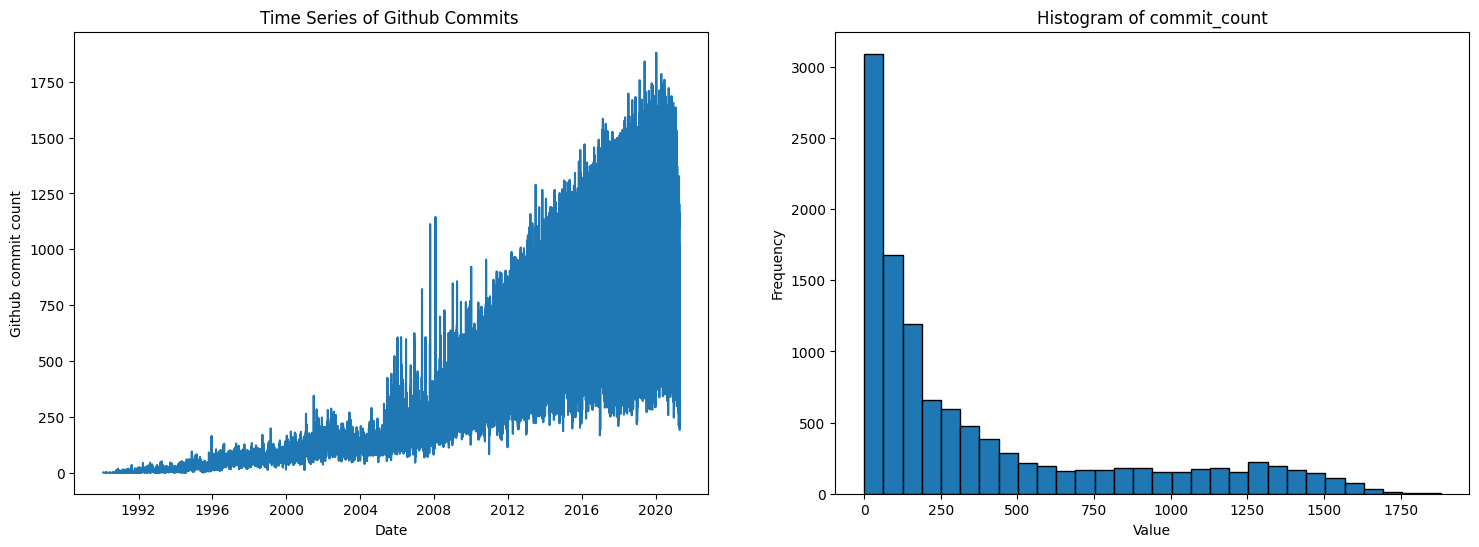

In [43]:
#taking half length of data
split = round(len(github_df_daily['commit_count'])/2)

# split two part of time series data
X1,X2 = github_df_daily['commit_count'][0:split],github_df_daily['commit_count'][split:]
mean1 ,mean2 = X1.mean() , X2.mean()
var1,var2 = X1.var() , X2.var()

#Check the stationarity of the time series based on the comparison of basic statistics
print("\nBefore difference mean and Variance\n")
print("mean1:",mean1)
print("mean2:",mean2)
print("var1:",var1)
print("var2:",var2)

fig ,ax = plt.subplots(1,2,figsize = (18,6))
ax[0].plot(github_df_daily['commit_count'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Github commit count")
ax[0].set_title("Time Series of Github Commits ")

# Histogram using Matplotlib
ax[1].hist(github_df_daily['commit_count'], bins=30, edgecolor='black')
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Histogram of commit_count")

plt.show()


From the visual inspection of time series plot it can be observed that -

- The graph reveals an **upward trend** in commit activity, indicative of a growing project engagement over time. Notably, following the introduction of Git in 2005, there was a gradual migration of projects to the platform. Furthermore, new repositories catering to diverse utilities such as OS, libraries etc. were incorporated at distinct time intervals


- There are appreciable **spikes** in commit activity, which could correspond to specific events such as project goals, or collaborative sprints

-  The **peak** followed by a slight **decline** could indicate a major release, after which activity naturally decreases

Next, the data is split into half to analyse if the mean and variance values vary drastically between the two periods. The mean and variance value change significantly through the series as calculated above establishing that there is dependency between time steps.


For a more detailed interpretation, it would be important to consider additional context such as repository specific events and contributor habits. In the next section, to streamline the data analysis process and facilitate more effective conclusions about repositories, a new mapping file has been added. This file categorizes repositories into specific categories, including Python libraries, compilers, and languages.

## 3.2 Data Analysis at repository level







Please **note** that the categorization of repositories is broad and has been undertaken to simplify the analysis.

In [44]:
rep_cat_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/repo_cat.csv')
rep_cat_df.head()

github_df_repo_all= pd.merge(github_df_repo_all,rep_cat_df,how='left',on='repo')

### 3.2.1 Analysis at the aggregated level

A comprehensive repository categorization has been established, allowing for the examination of key metrics such as the minimum and maximum commit dates, the total commit count, and the most frequent number of authors for each repository.

In [45]:
repo_summ= summarise_repo_level_info(github_df_repo_all)



<ipython-input-14-36e669142dff>:12: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  repo_summ= pd.merge(repo_summ,author_summ,on='repo',how="left")


In [46]:
repo_summ.sort_values(by=['datemin','commit_countsum'],inplace=True)


Creating a summary table to analyse the length of data available along with the number of commits by repositories

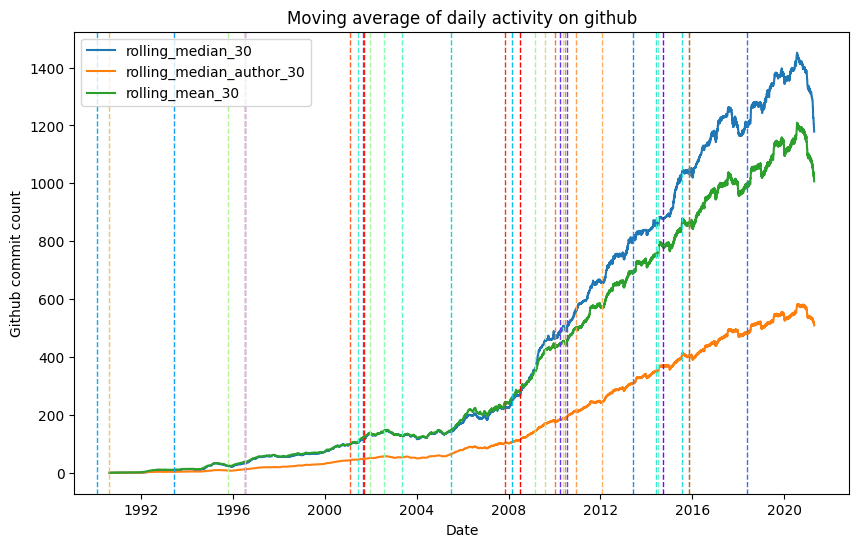

In [47]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(10, 6))

# Compute rolling mean and median with a window of 200
rolling_mean_30 = github_df_daily.commit_count.rolling(200).median()
ax.plot(rolling_mean_30,label='rolling_median_30')
author_mean_30 = github_df_daily.author_count.rolling(200).mean()
ax.plot(author_mean_30,label='rolling_median_author_30')

# Compute rolling mean with a window of 15
rolling_mean_15= github_df_daily.commit_count.rolling(200).mean()
ax.plot(rolling_mean_15,label='rolling_mean_30')
ax.set_title("Moving average of daily activity on github")
ax.set_xlabel("Date")
ax.set_ylabel("Github commit count")
ax.legend()
#for i in horizontal_marks:
horizontal_marks=repo_summ[['repo','datemin']]
colors = cm.rainbow(np.linspace(0, 1, len(horizontal_marks)))
for i in range(len(horizontal_marks)):
            ax.axvline(pd.to_datetime(horizontal_marks.loc[i,'datemin']), color=colors[i], linestyle='--', linewidth=1)
           # ax.legend()


Smoothing the time series with a simple average using a fixed window helps suppress noise and allows for observing the overall trend of the time series.Moving average and median analysis confirm a robust upward trend. The window size is determined through trial and error, and a comparison between median and mean is made because the median is more robust to outliers. A longer window size results in better noise suppression. Horizontal lines are used as markers to mark dates of first commit of each repo.


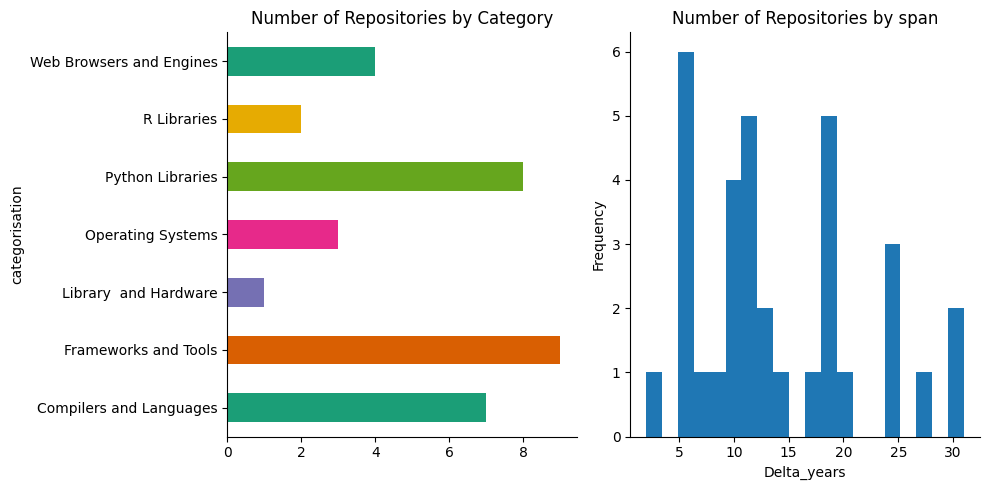

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with 1 row and 2 columns of subplots

# Bar plot for comparing the number of repositories by category
repo_summ.groupby('categorisation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axs[0])
axs[0].spines[['top', 'right']].set_visible(False)
axs[0].set_title("Number of Repositories by Category")

# Bar plot for comparing the number of repositories by span
repo_summ['delta_years'].plot(kind='hist', bins=20, title='years', ax=axs[1])
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_title("Number of Repositories by span")
axs[1].set_xlabel("Delta_years")
plt.tight_layout()

In [49]:
repo_summ.loc[(repo_summ['delta_years']>4) & (repo_summ['delta_years']<10) ]


,index,repo,datemin,datemax,commit_countsum,categorisation,author_count,delta_years,delta_months
25,25,pytorch/pytorch,2012-01-25,2021-04-20,35726.0,Python Libraries,7.086544,9,2
6,6,facebook/react,2013-05-28,2021-04-20,14078.0,Frameworks and Tools,2.628423,7,10
12,12,kubernetes/kubernetes,2014-06-06,2021-04-21,99961.0,Frameworks and Tools,16.777070,6,10
15,15,microsoft/TypeScript,2014-07-07,2021-04-21,32007.0,Compilers and Languages,4.646110,6,9
0,0,angular/angular,2014-09-18,2021-04-20,20721.0,Frameworks and Tools,5.147071,6,7
11,11,jupyterlab/jupyterlab,2015-07-23,2021-04-20,23156.0,Python Libraries,2.855646,5,8
30,30,tensorflow/tensorflow,2015-11-06,2021-04-20,109154.0,Frameworks and Tools,25.540893,5,5
16,16,microsoft/vscode,2015-11-13,2021-04-21,80577.0,Frameworks and Tools,10.879215,5,5


Commit activities can vary across different categories of repositories for several reasons:

1. **Nature of the Project**: Different types of repositories catering to various utilities may require varied levels of activity. For example, a language might require frequent updates to fix bugs, add feature leading to high commit activity. On the other hand, a completed Python library might only need occasional maintenance

2. **Size of the Contributor Community**: Projects with a large number of authors often have higher commit activity as more people are working on the project

3. **Release Cycles**: Some projects might have specific release cycles which could lead to peaks and troughs in commit activity.



It can be inferred that -



*   Most repositories in this analysis are between 5 to 15 years old on GitHub
*  Despite variations in project age, those with a sizable community of contributors generally exhibit higher commit activity, as indicated by the values in the 'author count' and 'Commit total sum' columns. This trend is attributed to the increased engagement of contributors actively working on the project



### 3.2.2 Analysing the git commit activity across time for repositories

In [50]:
##Display the unique values of categorisation
repo_summ['categorisation'].unique()

array(['Compilers and Languages', 'Operating Systems',
       'Web Browsers and Engines', 'Frameworks and Tools',
       'Python Libraries', 'R Libraries', 'Library  and Hardware'],
      dtype=object)

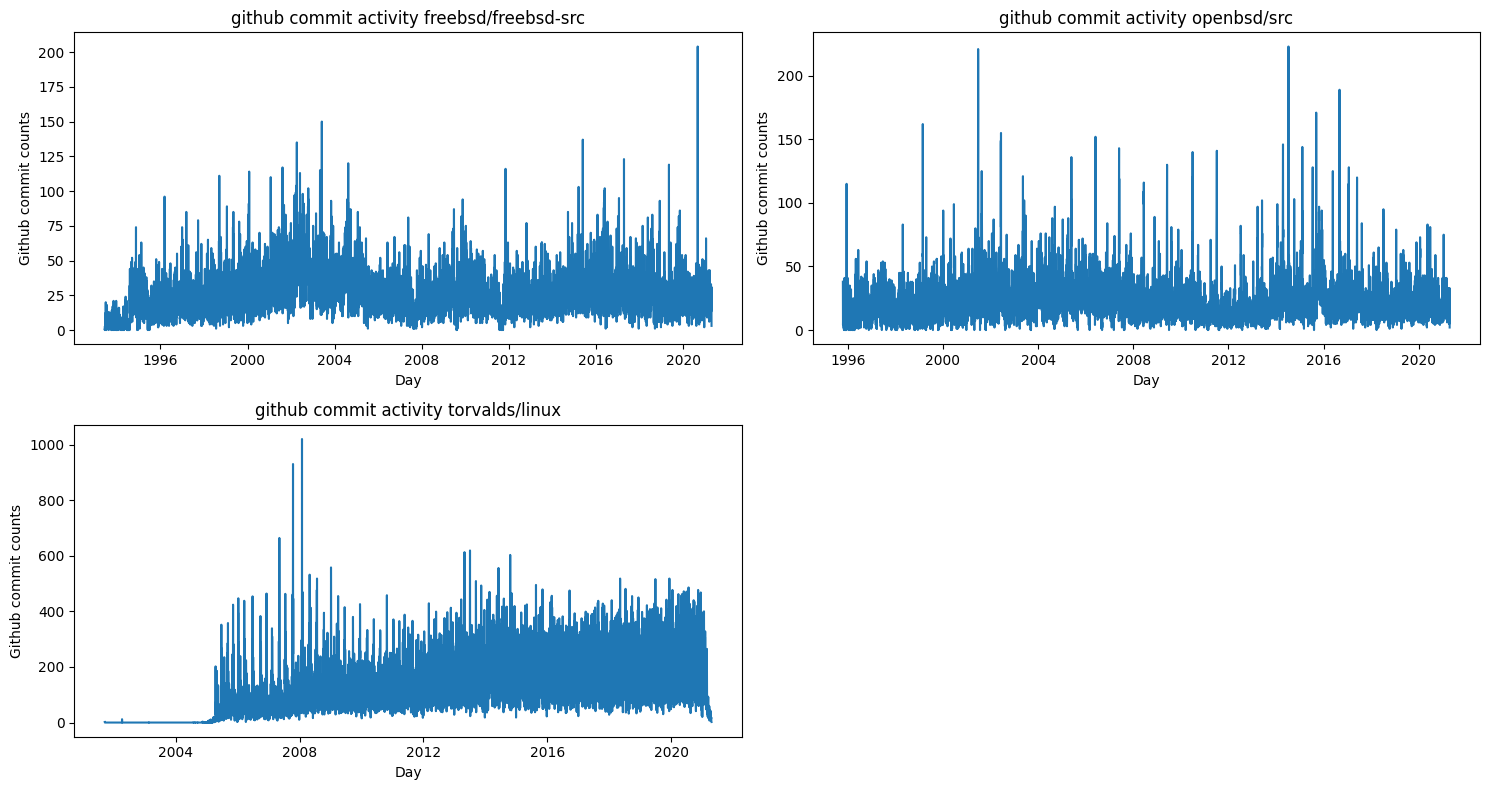

In [101]:
#Plot Time series for Operating Systems
plot_github_activity_repo(github_df_repo_all,'Operating Systems')

In [102]:
temp=github_df[(github_df['date']> '2008-06-01') & (github_df['date']<'2008-06-30')] # Analysing the number of commits across repositories in the mid of 2008
temp.groupby('repo')['commit'].count().sort_values

<bound method Series.sort_values of repo
apache/httpd              112
chromium/chromium         575
freebsd/freebsd-src       411
gcc-mirror/gcc            396
golang/go                 187
ipython/ipython            82
llvm/llvm-project         842
matplotlib/matplotlib     293
nginx/nginx                28
numpy/numpy                70
openbsd/src              1044
postgres/postgres          92
python/cpython            481
scipy/scipy                93
tidyverse/ggplot2          69
torvalds/linux           2868
Name: commit, dtype: int64>

**Observations on the time series of OS :**

1.torvalds/Linux
*  Change in the mean - The commit activities on github would have started anew after the release of git
*  After the intitiation of versioning on github it has been patterns of sudden peak and decline for instance in 2008 feature or version changes to versions 2.6.x
* Histroical commit history before 2004 is unavailable

2.openbsd
* Commit history is available more or less since inception in 1995
* The time series resembles a stationary process aside a few spikes and decline





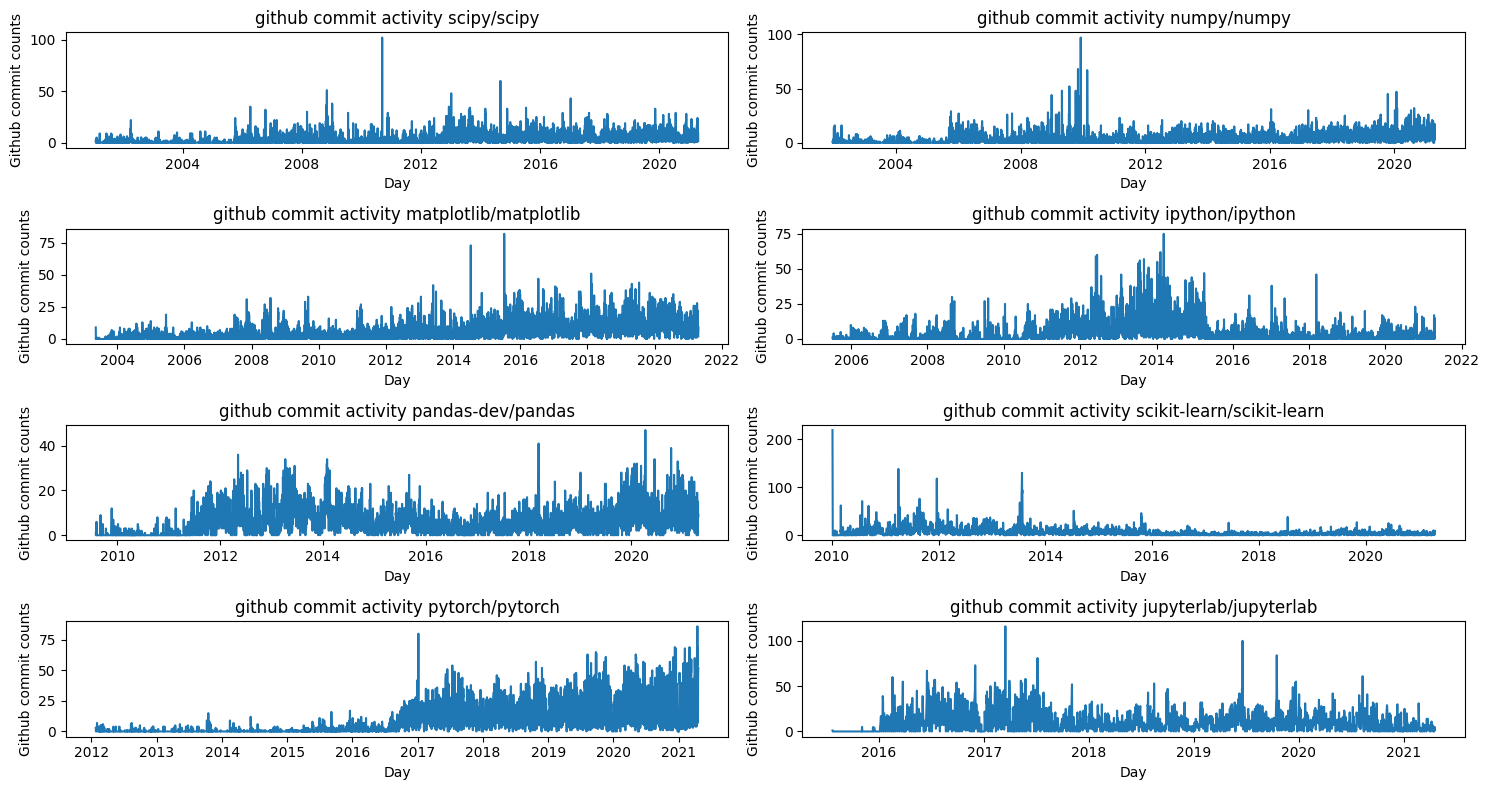

In [103]:
#Plot Time series for Python Libraries
plot_github_activity_repo(github_df_repo_all,'Python Libraries')

**Observations on the time series of Python Libraries :**

* Varying launch years for different libraries
* Pytorch is exhibiting level shift. In order to investigate further the number of unique contributors and commits are plotted together  
* Scikit learn has decreasing trend with respect to number of commits. It dips after 2014

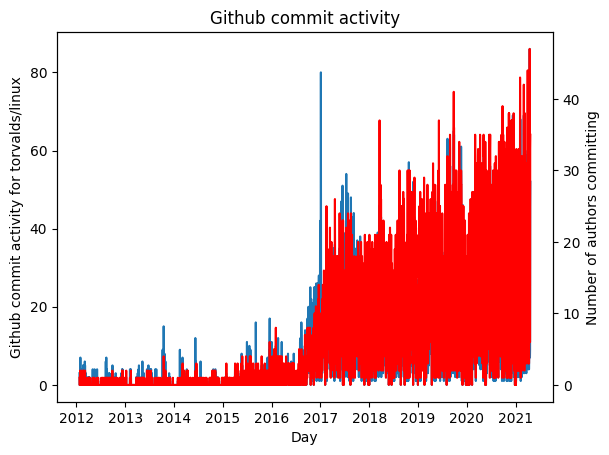

In [54]:

data = github_df_repo_all.loc[github_df_repo_all['repo'] == 'pytorch/pytorch']

# Create a new figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot commit count on the primary y-axis
ax1.plot(data['date'], data['commit_count'], label='Commit Count')
ax1.set_xlabel('Day')
ax1.set_ylabel('Github commit activity for torvalds/linux')

# Create a secondary y-axis for the same x-axis
ax2 = ax1.twinx()
# Plot author count on the secondary y-axis
ax2.plot(data['date'], data['author_count'], label='Author Count', color='r')
ax2.set_ylabel('Number of authors committing')
plt.title("Github commit activity")
# Show the plot
plt.show()


# 4 Time Series Decomposition

A time series comprises four essential components: level (average value), trend (increasing or decreasing pattern), seasonality (repeating short-term patterns), and noise/residual (random variations).








* In the subsequent analysis, the dataset is refined by focusing on information from the year 2005 onwards. It is highly likely that repositories with start dates before that were migrated to  Git system post-launch. However, it's essential to recognize that the migration process isn't always flawless

* While more data generally contributes to improved model, excessively long time series may contain outdated information or patterns that are no longer relevant

* To enhance relevance, the dataset is filtered to encompass data since git launch

In [55]:
# github_df_daily_fil - filtered dataset
github_df_daily_fil=github_df_daily.loc[github_df_daily.index>'2004-12-31']



Seasonal and Trend decomposition using Loess(STL) is a versatile technique for decomposing time series data.It employs Loess, a method for estimating nonlinear relationships. It  offers several advantages over classical and X11 decomposition methods. It is flexible enough to handle any kind of seasonality and it is robust to outliers. In the next section, decomposition is performed to analyse different components of time series closely.

Also, interactive plots are created using plotly's graph objects.




## 4.1 Trend Cycle Analysis for daily commit using regression and simple average

In [56]:
stl = STL(github_df_daily_fil["commit_count"],robust=True)
res = stl.fit()

In [57]:
decomp_plot_stl(github_df_daily_fil,keyword="trend",column="commit_count")

Performing a statistical to study the effect of linear trend in github daily activity. In regression trend estimation, we assume the trend-cycle component
follows a specific form including linear, quadratic, exponential etc.

In [58]:
github_df_daily_fil["day"]=[x.weekday() for x in github_df_daily_fil.index] # Extract day of the weeek from the index
github_df_daily_fil.head()

<ipython-input-58-778622738d2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,commit_count,author_count,day
date,,,
2005-01-01,84,35,5
2005-01-02,105,35,6
2005-01-03,144,56,0
2005-01-04,164,63,1
2005-01-05,146,70,2


In [59]:

#X is the dependent variable for time
# 'y' is your dependent variable
y = github_df_daily_fil['commit_count']
#github_df_daily_fil["day"]=[x.weekday() for x in github_df_daily_fil.index] #

X = sm.add_constant(github_df_daily_fil.day)

# Fit the ordinay least square model
model = sm.OLS(y, X).fit()

# Perform t-test for the slope
t_statistic = model.tvalues[1]
p_value = model.pvalues[1]

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Check if the linear trend is significant
alpha = 0.05
if p_value < alpha:
    print('The linear trend is significant.')
else:
    print('No significant linear trend.')


predictions = model.predict(X) # Get the fitted values


T-statistic: -35.117984970079455
P-value: 1.0351546478580803e-245
The linear trend is significant.


In [60]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           commit_count   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     1233.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.04e-245
Time:                        02:20:21   Log-Likelihood:                -44270.
No. Observations:                5955   AIC:                         8.854e+04
Df Residuals:                    5953   BIC:                         8.856e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        950.6329      9.569     99.341      0.000     931.873     969.392
day          -93.2049      2.654    -35.118      0.000     -98.408     -88.002
==============================================================================
Omnibus:                      285.838   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.817
Skew:                           0.414   Prob(JB):                     2.28e-52
Kurtosis:                       2.477   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results from linear regression and moving average analysis confirm a resilient upward trend. However, the lower R-squared in linear regression suggests here the linear assumptions may not be ideal for capturing the full complexity of the data.

## 4.2 Seasonal Analysis for daily commit using correlogram

The AutoCorrelation Factor (ACF) proves valuable for analyzing the autocorrelation at different lag points.The plot reveals a gradual decline with periodic oscillations
* Seasonal Fluctuations: The consistent ups and downs in the autocorrelation values at specific lags point to seasonal fluctuations in the data
* The presence or absence of short-term
correlation is hidden
* If the trend and seasonality are removed,
the ACF plot could give useful information

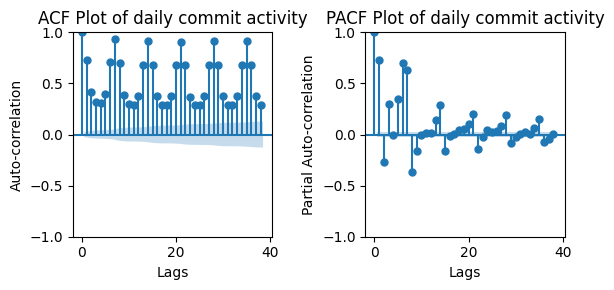

In [61]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(6,3))
plot_acf(github_df_daily_fil["commit_count"],title="ACF Plot of daily commit activity",ax=ax1) # Plotting auto correlation values at different lags
ax1.set_xlabel('Lags')
ax1.set_ylabel('Auto-correlation')
#fig,ax= plt.subplots(1,1,figsize=(4,3))
plot_pacf(github_df_daily_fil["commit_count"],title="PACF Plot of daily commit activity",ax=ax2) # Plotting auto correlation values at different lags
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Auto-correlation')
plt.tight_layout()
plt.show()


The pacf and acf plots are not converging.

In [62]:
decomp_plot_stl(github_df_daily_fil,keyword="seasonal",column="commit_count")

The seasonal component captures the behavior of commits over the week from Monday through Friday. Naturally, due to the weekend, there is a dip in the number of commits, and they increase after Monday.

## 4.3 Residual Analysis for daily commit

In [63]:
decomp_plot_stl(github_df_daily_fil,keyword="resid",column="commit_count")

Text(0, 0.5, 'Auto-correlation')

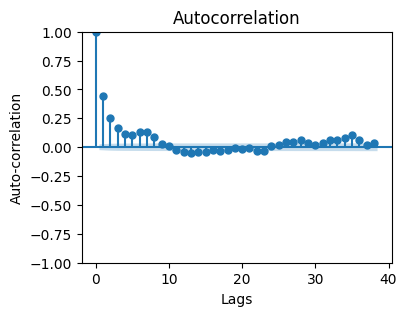

In [64]:
#Plotting the ACF of residuals devoid of seasonality and trend values
fig,ax= plt.subplots(1,1,figsize=(4,3))
plot_acf(res.resid,ax=ax)
ax.set_xlabel('Lags')
ax.set_ylabel('Auto-correlation')



Residual values are not stationary because there is depenency on the past time steps

* Initial Correlation: Strong positive autocorrelation at lower lags
* Decreasing Trend: Autocorrelation values decline as the lag increases

A **data transformation** is necessitated due to the combined impact of trend and seasonality revealed in the AutoCorrelation Function (ACF) plots and Partial AutoCorrelation Function (PACF) plots.

# **5 Time Series Forecasting - Univariate-time-series-forecasting**

In [65]:
#from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

Designing forecast models is a challenging process because modeling time series involves complex behavior particularly in the case of univariate time series that lacks cues from external regressors. It is a good practice to establish a baseline model, and subsequent steps can focus on further development.

As a preliminary analysis, from regression family ARIMA and SARIMA models are explored further.


**In this section forecasting methods capable of only looking at the target variable. There are no other regressors are added to the model. Scope of forecasting is going to be a week ahead.**

### **5.1.1 Preparing data for training on statistical models**

Day-level seasonality can lead to extended processing times and disruptions. Moreover, handling leap years can be inefficient. Due to practical considerations, forecasting is enhanced by transitioning to a weekly level. Additionally, to manage the long time series the dataset is streamlined by focusing on the most recent 10 years of data. This filtering is applied to the index, specifically capturing data from 2010 onwards

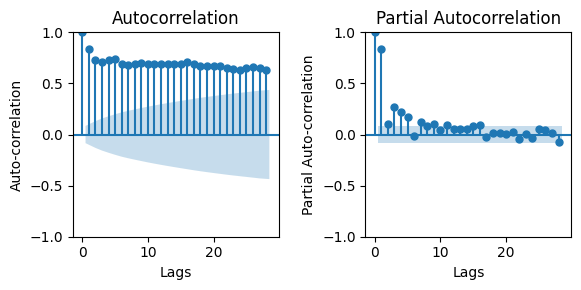

In [66]:
#github_df_daily_fcst=github_df_daily.loc[github_df_daily.index>'2005-12-31']
#Resampling to add weekly frquency to the index
github_df_weekly= github_df_daily.resample('W').agg({'commit_count':'sum','author_count':'sum'}) ##resampling at weekly level
github_df_weekly.head()
##Filtering the weekly data

github_df_weekly_fil=github_df_weekly[github_df_weekly.index>'2010-12-31']

fig,(ax1,ax2)= plt.subplots(1,2,figsize=(6,3))
plot_acf((github_df_weekly_fil['commit_count']),ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Auto-correlation')
plot_pacf((github_df_weekly_fil['commit_count']),ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Auto-correlation')
plt.tight_layout()
plt.show()


However, from the auto-correlation plots it can be concluded that there are still oscillations due to seasonality or structural break. Further it can be summarised that -

* AR processes have ACF values that do not converge to zero as the lag increases
* MA processes have PACF values seem to be converging as the lag increases
* Might need an integration step and have to be differentiated one time with possible value of d=1


In [67]:
diff_github_ts=github_df_weekly_fil['commit_count'].diff()  #np.diff(github_df_daily['commit_count']) #Taking the difference between the adjacent values from daily data

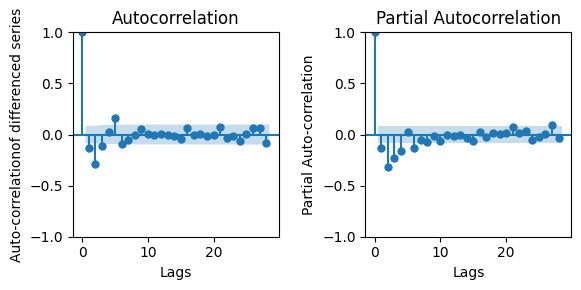

In [68]:
# Data Transformation and plotting ACF
#Plotting the ACF of residuals devoid of seasonality and trend values
fig,(ax1,ax2)= plt.subplots(1,2, figsize=(6,3))

# Taking the difference between adjacent values

plot_acf((diff_github_ts.dropna()),ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Auto-correlationof differenced series')
# Data Transformation and plotting PACF
# Taking the difference between adjacent values
plot_pacf(diff_github_ts.dropna(),ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Auto-correlation')

plt.tight_layout()
plt.show()


**Model Parameters:**

* If the sample PACF cuts off after lag p, an AR(p) model is needed

* If the sample ACF cuts off after lag q, an MA(q) model is needed

* AR(p) processes have PACF values that are small (near zero) for lags k > p. possible "p" term range is 0 to 2

* MA(q) processes have ACF values that are small for lags k > q. Possible "q" term range is 0 to 2

These values will provide the guidance in passing the grid search parameters in selecting the best regression model in terms of complexity and fitness in the next section.

**Dividing the data into train and test.Subset of 11 weeks from 2021 is used as the test dataset.**

In [69]:
train_series=github_df_weekly_fil.loc[github_df_weekly_fil.index<'2021-03-3'] ['commit_count']
test_series=github_df_weekly_fil.loc[(github_df_weekly_fil.index>='2021-02-01')& (github_df_weekly_fil.index<'2021-04-21')] ['commit_count']

In [ ]:
train_series

In [70]:
train_series   #.index.max()
test_series#.index.max()
print("Number of weeks for training:",len(train_series))
print("Number of weeks for testing:",len(test_series))

## Create an empty dictionary to track the performance
results_dict={}

# Saving the predictions values
pred_dict={}

Number of weeks for training: 531
Number of weeks for testing: 11


### **5.1.2 ARIMA/SARIMA model**

**ARIMA (AutoRegressive Integrated Moving Average)** is a forecasting algorithm that uses past data to predict future points in a time series, such as predicting stock prices or weather patterns. It operates on the principles of autocorrelation (the relationship between an observation and a lagged version of itself) and moving averages (averaging over a sliding window of past observations).

Pros:
*  Can capture a suite of different standard temporal structures in time series data.
* They are relatively straightforward to implement and understand.

Cons:
* Assume linearity and Gaussian errors, which may not hold * for all types of time series data.
* They can struggle with sudden, unexpected changes in the time series

Seasonal Autoregressive Integrated Moving Average, **SARIMA** or Seasonal ARIMA, is an extension of ARIMA that supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series.

**Seasonal Elements:**

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

* P: Seasonal autoregressive order
* D: Seasonal difference order
* Q: Seasonal moving average order
* m: The number of time steps for a single seasonal period

**Trend Elements:**

There are three trend elements that require configuration. They are:

* p: Trend autoregression order
* d: Trend difference order
* q: Trend moving average order

An Akaike Information -An Akaike Information Criterion (AIC) score is a number used to determine the best statistical model for a given dataset with the objective of achieving a balance between fit and complexity. A lower AIC score indicates a better trade-off between goodness of fit and model complexity

Fitting an auto_arima model to select the best parameter value based on AIC. The range values for grid parameters are already selected with the help of ACF and PACF plots.

In [71]:

# #Passing m as 52 to account for yearly seasonality in the commit activity

autoModel = pm.auto_arima(train_series.dropna(), trace=True, error_action='ignore',
                           suppress_warnings=False, seasonal=True, start_p=0, start_q=0,
                      max_p=2, max_q=2,m=52, stepwise=True)
results=autoModel.fit(train_series)

In [72]:
# Constructing the model based on the best parameters selected
arima_model = sm.tsa.SARIMAX(train_series, trend='c', order=(0,1,0), seasonal_order=(1,0,2,52),enforce_stationarity=False, enforce_invertibility=False) #ARIMA(train_series.dropna(),order=(1,0,2))
res_arima_model=arima_model.fit()

In [73]:
#Displaying model summary
res_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            commit_count   No. Observations:                  531
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2], 52)   Log Likelihood               -3319.805
Date:                                 Sat, 16 Dec 2023   AIC                           6649.611
Time:                                         02:22:00   BIC                           6669.871
Sample:                                     01-02-2011   HQIC                          6657.615
                                          - 02-28-2021                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.0084     32.128      0.187      0.852     -56.962      68.978
ar.S.L52       0.7562      0.054     14.085      0.000       0.651       0.861
ma.S.L52      -0.0578      0.072     -0.808      0.419      -0.198       0.082
ma.S.L104      0.1331      0.070      1.891      0.059      -0.005       0.271
sigma2      3.564e+05   1.62e+04     21.962      0.000    3.25e+05    3.88e+05
===================================================================================
Ljung-Box (L1) (Q):                  45.29   Jarque-Bera (JB):               270.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -0.57
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficient values represent the seasonal orders P and Q. It can be concluded that ar.S.L52 and ma.S.L104 are significant, as their p-values fall below the critical value with 90% confidence

**Plot the forecasted value against the actual value to visually assess the forecast values and perform residual analysis.** Further, instead of forecasting for 11 weeks together the horizon is shortened to immediate four weeks (1 month) which is tested after performing model diagnostics.

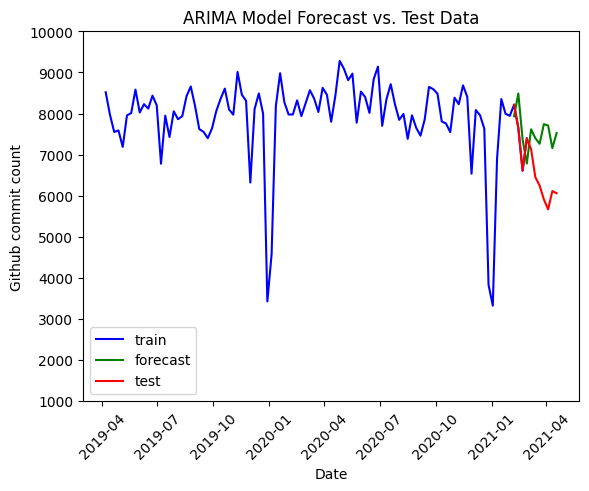

In [74]:
# Make your forecast
# forecasts = results.predict(start=90, end=103, dynamic=True)  # predict N steps into the future
forecasts = res_arima_model.predict(start=test_series.index[0], end=test_series.index[-1])
forecast_series = pd.Series(forecasts, index=test_series.index[:len(forecasts)])

# Visualize the forecasts, train, and test data
plt.plot(train_series[train_series.shape[0]-100:train_series.shape[0]], label='train', c='blue')
plt.plot(forecast_series, label='forecast', c='green')

# Plot the test data
plt.plot(test_series, label='test', c='red')

# Add title and labels
plt.title('ARIMA Model Forecast vs. Test Data')
plt.xlabel('Date')
plt.ylabel('Github commit count')

# Tilt x-axis
plt.xticks(rotation=45)
plt.ylim(1000,10000)
plt.legend(loc='best')
plt.show()


In [75]:
#Training Error
train_fit= res_arima_model.fittedvalues
print("Training error:",evaluate_res(train_fit[1:], train_series[1:]))

#Testing Error

print("Test error on 11 weeks:",evaluate_res(forecast_series, test_series))



Training error: {'calculate_mae': 436.41698741328656, 'calculate_mape': 7.620898438755747, 'calculate_variance': 2312763.1795656816, 'calculate_bias': 5.78298767254543}
Test error on 11 weeks: {'calculate_mae': 1029.5364836762228, 'calculate_mape': 13.650763936297514, 'calculate_variance': 598525.7024793387, 'calculate_bias': 867.5288850387659}


In [89]:
i=0
results_dict[f'ARIMA_train_{i}'] = evaluate_res(train_fit[1:], train_series[1:])
results_dict[f'ARIMA_test_{i}'] = evaluate_res(forecast_series, test_series)


**Model Diagnostics**

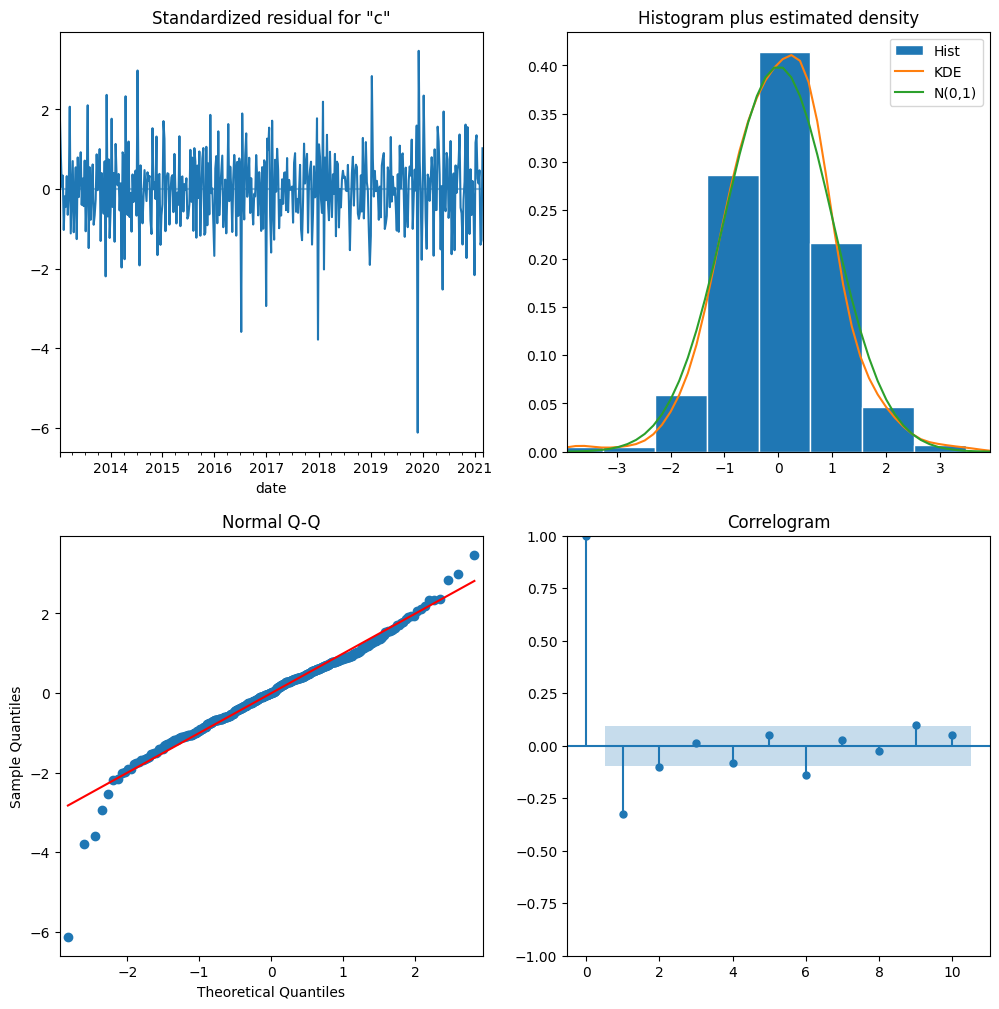

In [76]:
res_arima_model.plot_diagnostics(figsize=(12, 12))
plt.show()

**Observations on model residuals:**

* The residuals fluctuate without a clear pattern, suggesting that the model captures the data's inherent structure well

* The histogram and estimated density indicate that residuals are approximately normally distributed

* The alignment of sample quantiles with theoretical quantiles suggests that the residuals follow a normal distribution

* The autocorrelations for different lags are within the confidence interval, implying that residuals values are independent

**To assess the performance of the model rolling window validation is performed in the incremental steps of size 4 weeks**

It can be dynamically changed for testing on different windows. The assessment is made by using error metrics such as MAE, MAPE, variance and bias.



In [ ]:
#i=0
step_size=1
fcst_len=4
for i in range(1, 5, step_size):
        current_test_subset = test_series[:i+step_size]

        # Append the current test subset to the training set
        current_train_data = train_series.append(current_test_subset)
        current_train_data=current_train_data.reset_index()
        # Constructing the model based on the best parameters selected
        arima_model_n = sm.tsa.SARIMAX(current_train_data, trend='c', order=(0,1,0), seasonal_order=(1,0,2,52), enforce_stationarity=False, enforce_invertibility=False)
        res_arima_model_n = arima_model_n.fit()

        # Make predictions
        forecasts = res_arima_model_n.predict(start=len(current_train_data), end=len(current_train_data)+fcst_len-1)
        train_fit= res_arima_model_n.fittedvalues
        results_dict[f'ARIMA_train_{i}'] = evaluate_res(current_train_data, train_fit)
        results_dict[f'ARIMA_test_{i}'] = evaluate_res(test_series[i+step_size:(i+step_size)+4].values, forecasts)


In [90]:
results_dict

{'ARIMA_train_1': {'calculate_mae': 438.9013434325335,
  'calculate_mape': 8.02704361858842,
  'calculate_variance': 2325102.205949176,
  'calculate_bias': -2.677489809626905},
 'ARIMA_test_1': {'calculate_mae': 824.221256600191,
  'calculate_mape': 12.09130537274879,
  'calculate_variance': 68179.09488196397,
  'calculate_bias': -824.221256600191},
 'ARIMA_train_2': {'calculate_mae': 439.768225692531,
  'calculate_mape': 8.034571347167569,
  'calculate_variance': 2324876.276355423,
  'calculate_bias': -2.4011582231826},
 'ARIMA_test_2': {'calculate_mae': 265.83497240559427,
  'calculate_mape': 4.019017843497343,
  'calculate_variance': 54897.01262231324,
  'calculate_bias': -72.14245131385314},
 'ARIMA_train_3': {'calculate_mae': 439.54943284703245,
  'calculate_mape': 8.02807373948566,
  'calculate_variance': 2322312.205762112,
  'calculate_bias': -2.8797612989290844},
 'ARIMA_test_3': {'calculate_mae': 834.0628921147227,
  'calculate_mape': 13.609817955747191,
  'calculate_variance'

In [92]:
substring1="train" #Extract the train errors to summarise mape and mae using keyword match
substring2="test" #Extract the test errors to summarise mape and mae using keyword match

train_mape=[]
test_mape=[]
train_mae=[]
test_mae=[]

for key in results_dict.keys():
    if key.find(substring1) > -1:
        # print(results_dict[key]['calculate_mape'])
        train_mape.append(results_dict[key]['calculate_mape'])
        train_mae.append(results_dict[key]['calculate_mae'])
        #print(f"'{substring}' found in key '{key}', value: {my_dict[key]}")

    if key.find(substring2) > -1:

        test_mape.append(results_dict[key]['calculate_mape'])
        test_mae.append(results_dict[key]['calculate_mae'])

     #   print(f"'{substring2}' found in key '{key}', value: {my_dict[key]}")

In [99]:
print("Training average MAE:",np.mean(train_mae))
print("Testing average MAE:",np.mean(test_mae))
print("Training average MAPE:",np.mean(train_mape))
print("Testing average MAPE:",np.mean(test_mape))

Training average MAE: 438.9200004580957
Testing average MAE: 799.7398807487928
Training average MAPE: 7.945551022786972
Testing average MAPE: 12.2321247549562


The Mean Absolute Error (MAE) for the training data is approximately 438.92, the model’s predictions are about 438.92 units away from the actual values while  MAE for the testing data is approximately 799.74, indicating that the model’s predictions are about 799.74 units away from the actual values in the testing data on average.

While the MAPE values seem to be closer between the train and test with a delta of 5% between them.



Based on the assessment of the  results dictionary it can be concluded that -

* Bias is skewed exclusively in a negative direction, indicating an overestimation in the prediction in case of both training and test dataset

* MAE values do not exhibit consistent behavior however there is no drastic fluctuations for test set while training set has consistent mae

* Additionally, the incorporation of MAPE facilitates easy comprehension, and it's worth noting that underpredictions are comparatively less penalized

**Key Findings:**

* **Data Alignment:** Rectifying discrepancies in the timeline, records from the future and past were corrected for specific repositories. To address potential gaps in GitHub activity on days without commits, a continuous date index was established at the repository level. This ensures a comprehensive timeline, facilitating effective time series analysis, even on days with no recorded commits

* **Diverse Repository Dynamics:** While the overall activity time series exhibited an upward trend, individual repositories displayed varied characteristics, including upward trends, downtrends, and level shifts. These differences in repository activities are influenced by specific events, project goals, and other factors

* **Time Series Decomposition:** Decomposition analyses revealed a prominent presence of both trend and seasonal characteristics in the overall time series. However, the day-level variations were notably high, introducing volatility to the system. To mitigate this, the data was aggregated to a weekly level, enhancing its suitability for forecasting purposes.

* **Forecasting:**  Primary goal in forecasting is to establish a baseline model based on univariate time series. Preceding forecasting, a meticulous study of correlation in the data guides the determination of trend and seasonal orders in SARIMA models. The forecast's efficacy is evaluated through a window or rolling method with prediction window of four weeks, measuring average MAPE and MAE values, which are reported as 12 % and 800 respectively.



**Suggested actions:**

* Conduct repo-level forecasting due to diverse repo behaviors (as discussed in section 3)

* Fine-tune model parameters (p, d, q, P, D, Q) using a validation test set

* Enhance ARIMA model fit by incorporating exogenous variables

* Explore alternative models







# 6 References:

1. FORECASTING: PRINCIPLES AND PRACTICE By Rob J Hyndman and George Athanasopoulos
https://otexts.com/fpp2/

2. Applied Time Series Analysis, https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html

3. Plotly for interactive plots - https://plotly.com/python/reference/layout/sliders/

4. Matplotlib: https://matplotlib.org/stable/

5. Statsmodels: https://www.statsmodels.org/dev/examples/notebooks/generated/stl_decomposition.html